In [1]:
!git clone --recurse-submodules https://github.com/cvg/DeepLSD.git
!cd DeepLSD
!mkdir weights
!wget https://www.polybox.ethz.ch/index.php/s/FQWGkH57UNTqlJZ/download -O weights/deeplsd_wireframe.tar
!wget https://www.polybox.ethz.ch/index.php/s/XVb30sUyuJttFys/download -O weights/deeplsd_md.tar
!bash quickstart_install.sh

fatal: destination path 'DeepLSD' already exists and is not an empty directory.
A subdirectory or file weights already exists.
--2024-06-26 09:32:20--  https://www.polybox.ethz.ch/index.php/s/FQWGkH57UNTqlJZ/download
Resolving www.polybox.ethz.ch (www.polybox.ethz.ch)... 129.132.71.243
Connecting to www.polybox.ethz.ch (www.polybox.ethz.ch)|129.132.71.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102898321 (98M) [application/x-tar]
Saving to: 'weights/deeplsd_wireframe.tar'

     0K .......... .......... .......... .......... ..........  0% 92.0K 18m12s
    50K .......... .......... .......... .......... ..........  0%  185K 13m37s
   100K .......... .......... .......... .......... ..........  0% 2.64M 9m17s
   150K .......... .......... .......... .......... ..........  0% 25.6M 6m58s
   200K .......... .......... .......... .......... ..........  0%  192K 7m19s
   250K .......... .......... .......... .......... ..........  0% 1.10M 6m20s
   300K ....

In [30]:
!git clone https://github.com/thygate/stable-diffusion-webui-depthmap-script.git -q 

!pip install opencv-python -q
!pip install torch torchvision torchaudio -q
!pip install matplotlib -q
!pip install git+https://github.com/facebookresearch/segment-anything.git -q 

!pip install largestinteriorrectangle -q 

In [31]:
#change direction temporarily to "stable-diffusion-webui-depthmap-script" for installing requirements
%cd stable-diffusion-webui-depthmap-script
!pip install -q -r requirements.txt

c:\Users\ASUS\Documents\GitHub\Streamlit-video-process\stable-diffusion-webui-depthmap-script


In [32]:
# einops isn't in requirements.txt but it's necesssary!
!pip install -q einops

In [1]:
import sys; print(sys.path)

['c:\\Users\\ASUS\\miniconda3\\python311.zip', 'c:\\Users\\ASUS\\miniconda3\\DLLs', 'c:\\Users\\ASUS\\miniconda3\\Lib', 'c:\\Users\\ASUS\\miniconda3', '', 'C:\\Users\\ASUS\\AppData\\Roaming\\Python\\Python311\\site-packages', 'c:\\Users\\ASUS\\miniconda3\\Lib\\site-packages', 'c:\\users\\asus\\deeplsd\\third_party\\afm_lib', 'c:\\users\\asus\\deeplsd', 'c:\\Users\\ASUS\\miniconda3\\Lib\\site-packages\\win32', 'c:\\Users\\ASUS\\miniconda3\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\ASUS\\miniconda3\\Lib\\site-packages\\Pythonwin']


In [2]:
%cd stable-diffusion-webui-depthmap-script
from src import backbone
from src.depthmap_generation import ModelHolder

c:\Users\ASUS\Documents\GitHub\Streamlit-video-process\stable-diffusion-webui-depthmap-script
  The standalone mode is not on par with the stable-diffusion-webui mode.
  Some features may be missing or work differently. Please report bugs.



c:\Users\ASUS\Documents\GitHub\Streamlit-video-process\stable-diffusion-webui-depthmap-script\dmidas\backbones\next_vit.py:435: UserWarning: Overwriting nextvit_small in registry with dmidas.backbones.next_vit.nextvit_small. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
c:\Users\ASUS\Documents\GitHub\Streamlit-video-process\stable-diffusion-webui-depthmap-script\dmidas\backbones\next_vit.py:441: UserWarning: Overwriting nextvit_base in registry with dmidas.backbones.next_vit.nextvit_base. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
c:\Users\ASUS\Documents\GitHub\Streamlit-video-process\stable-diffusion-webui-depthmap-script\dmidas\backbones\next_vit.py:447: UserWarning: Overwriting nextvit_large in registry with dmidas.backbones.next_vit.nextvit_large. This is because the name being registered conflicts with an exist

In [3]:
%cd ..
import numpy as np
import torch
import largestinteriorrectangle as lir
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator


c:\Users\ASUS\Documents\GitHub\Streamlit-video-process


In [4]:
import os
import gc
import cv2
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from typing import List, Tuple
from numpy.typing import NDArray
import math
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap as lsc
import torch
from deeplsd.utils.tensor import batch_to_device
from deeplsd.models.deeplsd_inference import DeepLSD
from deeplsd.geometry.viz_2d import plot_images, plot_lines
from PIL import Image, ImageFilter

[06/26/2024 10:04:17 INFO] Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[06/26/2024 10:04:17 INFO] NumExpr defaulting to 8 threads.


In [5]:
USE_DEPTHMAP = True  # True: use depthmap, False: automatically detect

# Define paths to SAM checkpoints,
# "sam_vit_b" is the base model,
# "sam_vit_l" is the large model,
# "sam_vit_h" is the huge model,
# read README.md in folder /SAM for more information
RUNTIME_ENV = "colab"  # "colab" or "local"
SAM_CKPT_B = "sam_vit_b_01ec64.pth" if RUNTIME_ENV == "colab" else "sam/sam_vit_b_01ec64.pth"
SAM_CKPT_L = "sam_vit_l_0b3195.pth" if RUNTIME_ENV == "colab" else "sam/sam_vit_l_0b3195.pth"
SAM_CKPT_H = "sam_vit_h_4b8939.pth" if RUNTIME_ENV == "colab" else "sam/sam_vit_h_4b8939.pth"

# Select SAM model type
MODEL_TYPE = "vit_h"
MODEL_WEIGHTS = SAM_CKPT_H

# Set target ratio of black area in binarized images
TARGET_RATIO = 60

In [6]:
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator

In [7]:
import os

download_link = {
    SAM_CKPT_B: "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth",
    SAM_CKPT_L: "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth",
    SAM_CKPT_H: "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth",
}

if not os.path.exists(MODEL_WEIGHTS):
  !wget {download_link[MODEL_WEIGHTS]} -O {MODEL_WEIGHTS}
  
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Load SAM model
SAM = sam_model_registry[MODEL_TYPE](checkpoint=MODEL_WEIGHTS)
SAM.to(device=DEVICE)

# Select SAM predictor
PREDICTOR = SamPredictor(SAM) if USE_DEPTHMAP else SamAutomaticMaskGenerator(SAM)

In [9]:
# load model
(device := torch.device("cuda" if torch.cuda.is_available() else "cpu"))
model_holder = ModelHolder()
ops = backbone.gather_ops()
model_holder.update_settings(**ops)
model_holder.ensure_models(0, device, False)

Loading model weights from  ./models/leres/res101.pth


100%|██████████| 506M/506M [00:48<00:00, 10.9MB/s]   


## Function

In [10]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [11]:
def classify_lines_with_slope(out: dict) -> Tuple[NDArray[np.float32], NDArray[np.float32]]:
    lines = out['lines'][0]
    x1, y1 = lines[:, 0, 0], lines[:, 0, 1]
    x2, y2 = lines[:, 1, 0], lines[:, 1, 1]

    vertical_mask = x2 == x1
    slopes = np.where(vertical_mask, np.Infinity, (y2 - y1) / (x2 - x1))
    horizontal_mask = np.abs(slopes) <= 1

    vertical_lines = lines[vertical_mask | ~horizontal_mask]
    horizontal_lines = lines[horizontal_mask]

    return horizontal_lines, vertical_lines


## Generate Segmentation with Bounding Box

In [12]:
def Box_to_Segmentation(points):
    mask_predictor = SamPredictor(SAM)
    min_x = min(point[0] for point in points)
    min_y = min(point[1] for point in points)
    max_x = max(point[0] for point in points)
    max_y = max(point[1] for point in points)

    width = max_x - min_x
    height = max_y - min_y

    # 生成 default_box
    default_box = {'x': min_x, 'y': min_y, 'width': width, 'height': height, 'label': ''}
    box = default_box
    box = np.array([
        box['x'],
        box['y'],
        box['x'] + box['width'],
        box['y'] + box['height']
    ])

    #Predictor masks
    image_bgr = cv2.imread('recording_room.jpg')
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    mask_predictor.set_image(image_rgb)

    masks, scores, logits = mask_predictor.predict(
        box=box,
        multimask_output=True
    )

    coordinates = np.argwhere(masks == 1)
    return coordinates


SupervisionWarnings: red is deprecated: `Color.red()` is deprecated and will be removed in `supervision-0.22.0`. Use `Color.RED` instead.
SupervisionWarnings: red is deprecated: `Color.red()` is deprecated and will be removed in `supervision-0.22.0`. Use `Color.RED` instead.
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


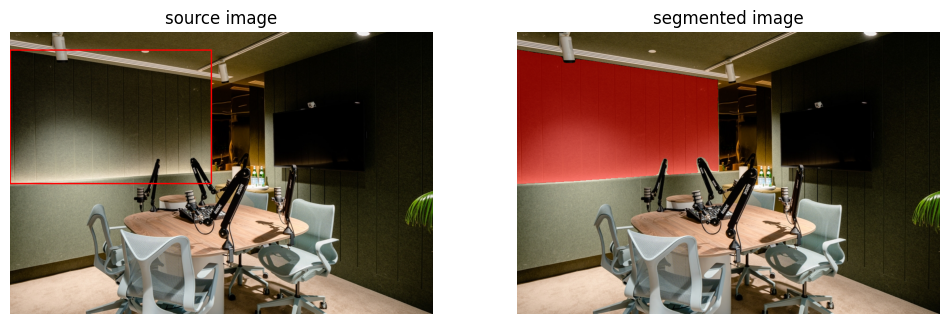

In [13]:
import cv2
import numpy as np
import supervision as sv
import numpy as np
from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image('recording_room.jpg')
widget

mask_predictor = SamPredictor(SAM)
# default_box is going to be used if you will not draw any box on image above
points = [(2, 37), (430, 295), (427, 104), (0, 323)]

# 分别找到最小和最大的x, y值
min_x = min(point[0] for point in points)
min_y = min(point[1] for point in points)
max_x = max(point[0] for point in points)
max_y = max(point[1] for point in points)

# 计算宽度和高度
width = max_x - min_x
height = max_y - min_y

# 生成 default_box
default_box = {'x': min_x, 'y': min_y, 'width': width, 'height': height, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

image_bgr = cv2.imread('recording_room.jpg')
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red(), color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [14]:
masks

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [15]:
coordinates = np.argwhere(masks == 1)

In [16]:
coordinates

array([[  0,  39,   2],
       [  0,  39,   3],
       [  0,  39,   4],
       ...,
       [  2, 322,  17],
       [  2, 322,  18],
       [  2, 322,  19]], dtype=int64)

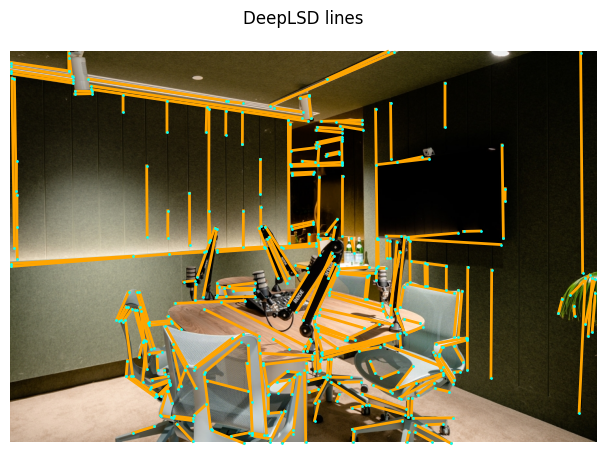

In [17]:
# Load an image
img = cv2.imread('recording_room.jpg')[:, :, ::-1]
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Model config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
conf = {
    'detect_lines': True,  # Whether to detect lines or only distance field/angle field
    'line_detection_params': {
        'merge': True,  # Whether to merge close-by lines
        'filtering': True,  # Whether to filter out lines based on the distance field/angle field. Use 'strict' to get an even stricter filtering
        'grad_thresh': 2,
        'grad_nfa': True,  # If True, use the image gradient and the NFA score of LSD to further threshold lines. We recommand using it for easy images, but to turn it off for challenging images (e.g. night, foggy, blurry images)
    }
}

# Load the model
ckpt = 'C:/Users/ASUS/DeepLSD/weights/deeplsd_md.tar'
# ckpt = '/Volumes/Seagate Bac/models/computer_vision/deeplsd/deeplsd_md.tar' # outdoor
# ckpt = '/Volumes/Seagate Bac/models/computer_vision/deeplsd/deeplsd_wireframe.tar' # indoor
ckpt = torch.load(str(ckpt), map_location='cpu')
net = DeepLSD(conf)
net.load_state_dict(ckpt['model'])
net = net.to(device).eval()

# Load an image
img = cv2.imread('recording_room.jpg')[:, :, ::-1]
kernel_sharpening = np.array([[-1,-1,-1], 
                              [-1, 9,-1],
                              [-1,-1,-1]])
sharpened = cv2.filter2D(img,-1,kernel_sharpening)
gray_img = cv2.cvtColor(sharpened, cv2.COLOR_RGB2GRAY)

# Detect (and optionally refine) the lines
inputs = {'image': torch.tensor(gray_img, dtype=torch.float, device=device)[None, None] / 255.}
with torch.no_grad():
    out = net(inputs)
    pred_lines = out['lines'][0]

# Plot the predictions
plot_images([img], ['DeepLSD lines'], cmaps='gray')
plot_lines([pred_lines], indices=range(1))

In [18]:
pred_lines

array([[[391.64276 , 268.23117 ],
        [439.6961  , 342.49084 ]],

       [[394.5873  , 287.62396 ],
        [424.57272 , 355.51376 ]],

       [[381.30658 , 270.42606 ],
        [410.9654  , 347.24115 ]],

       ...,

       [[  9.025417, 213.00029 ],
        [  9.530355, 168.00595 ]],

       [[526.3531  , 599.19684 ],
        [527.35443 , 582.1382  ]],

       [[241.60883 , 285.99152 ],
        [241.8649  , 243.99918 ]]], dtype=float32)

### 擴展5%

In [19]:
import numpy as np
import cv2
from concurrent.futures import ThreadPoolExecutor


# Step 1: Create a binary mask image
height, width = 1024, 1024  # Adjust based on your actual image dimensions
binary_mask = np.zeros((height, width), dtype=np.uint8)
mask_coords = np.argwhere(masks == 1)
for coord in mask_coords:
    binary_mask[coord[1], coord[2]] = 1  # Set the pixels of the mask to 1

# Expand the mask using dilation
kernel_size = int(max(height, width) * 0.05)  # Kernel size as 5% of the dimensions
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
binary_mask = cv2.dilate(binary_mask, kernel)

# Step 2: Define a function to rasterize lines
def rasterize_line(img, line):
    pt1, pt2 = (int(line[0][0]), int(line[0][1])), (int(line[1][0]), int(line[1][1]))
    cv2.line(img, pt1, pt2, color=1, thickness=1)

# Step 3: Check for intersections
line_segments = pred_lines  # Ensure 'pred_lines' is defined as your lines data from DeepLSD
intersecting_lines = []
for line in line_segments:
    line_img = np.zeros_like(binary_mask)
    rasterize_line(line_img, line)
    if np.any(np.logical_and(binary_mask, line_img)):
        intersecting_lines.append(line)

# Output the intersecting lines
print("Intersecting Lines:", intersecting_lines)


Intersecting Lines: [array([[391.64276, 268.23117],
       [439.6961 , 342.49084]], dtype=float32), array([[394.5873 , 287.62396],
       [424.57272, 355.51376]], dtype=float32), array([[381.30658, 270.42606],
       [410.9654 , 347.24115]], dtype=float32), array([[426.89838, 104.00047],
       [427.7829 , 294.001  ]], dtype=float32), array([[  0.8757927, 329.43106  ],
       [301.1315   , 305.66098  ]], dtype=float32), array([[89.56016  ,  1.0060295],
       [89.95782  , 30.014286 ]], dtype=float32), array([[296.17184, 376.03452],
       [317.1369 , 271.6259 ]], dtype=float32), array([[414.95175, 299.54883],
       [469.9641 , 293.66446]], dtype=float32), array([[316.9219 , 303.73026],
       [390.01447, 299.2352 ]], dtype=float32), array([[318.07257, 307.03333],
       [391.055  , 301.80872]], dtype=float32), array([[287.32138, 345.17874],
       [313.77814, 270.63104]], dtype=float32), array([[397.91037, 284.562  ],
       [428.3788 , 347.89337]], dtype=float32), array([[124.63216 ,

### 原始

In [20]:
##Define a function to rasterize lines
def rasterize_line(img, line):
    pt1, pt2 = (int(line[0][0]), int(line[0][1])), (int(line[1][0]), int(line[1][1]))
    cv2.line(img, pt1, pt2, color=1, thickness=1)

def find_intersecting_lines(masks_find_interline, pred_lines_find_interline):
    ##Create a binary mask image
    height, width = 1024, 1024 # Adjust based on your actual image dimensions
    binary_mask = np.zeros((height, width), dtype=np.uint8)
    mask_coords = np.argwhere(masks_find_interline == 1)
    for coord in mask_coords:
        binary_mask[coord[1], coord[2]] = 1 # Set the pixels of the mask to 1

    line_segments = pred_lines_find_interline
    intersecting_lines = []
    for line in line_segments:
        line_img = np.zeros_like(binary_mask)
        rasterize_line(line_img, line)
        if np.any(np.logical_and(binary_mask, line_img)):
            intersecting_lines.append(line)
    return intersecting_lines

In [21]:
intersecting_lines = find_intersecting_lines(masks, pred_lines)
intersecting_lines

[array([[381.30658, 270.42606],
        [410.9654 , 347.24115]], dtype=float32),
 array([[426.89838, 104.00047],
        [427.7829 , 294.001  ]], dtype=float32),
 array([[316.9219 , 303.73026],
        [390.01447, 299.2352 ]], dtype=float32),
 array([[124.63216 ,  57.498013],
        [456.7923  , 106.41059 ]], dtype=float32),
 array([[304.5976 , 243.96968],
        [306.87756, 288.90472]], dtype=float32),
 array([[  6.2362027,  40.965977 ],
        [ 10.596194 , 317.9754   ]], dtype=float32),
 array([[209.42235, 175.00345],
        [210.0738 , 284.00552]], dtype=float32),
 array([[357.73184, 300.0023 ],
        [357.90613, 243.99971]], dtype=float32),
 array([[  0.95315385, 325.2517    ],
        [187.97142   , 313.54358   ]], dtype=float32),
 array([[240.44981,  75.99889],
        [240.56525, 123.00107]], dtype=float32),
 array([[304.61646, 292.00333],
        [305.03488,  88.00007]], dtype=float32),
 array([[356.3216 , 142.00119],
        [356.50262,  92.99816]], dtype=float32),
 arr

In [22]:
import numpy as np
import cv2

##Step 1: Create a binary mask image
height, width = 1024, 1024 # Adjust based on your actual image dimensions
binary_mask = np.zeros((height, width), dtype=np.uint8)
mask_coords = np.argwhere(masks == 1)
for coord in mask_coords:
    binary_mask[coord[1], coord[2]] = 1 # Set the pixels of the mask to 1

##Step 2: Define a function to rasterize lines
def rasterize_line(img, line):
    pt1, pt2 = (int(line[0][0]), int(line[0][1])), (int(line[1][0]), int(line[1][1]))
    cv2.line(img, pt1, pt2, color=1, thickness=1)

##Step 3: Check for intersections
line_segments = pred_lines
intersecting_lines = []
for line in line_segments:
    line_img = np.zeros_like(binary_mask)
    rasterize_line(line_img, line)
    if np.any(np.logical_and(binary_mask, line_img)):
        intersecting_lines.append(line)

##Output the intersecting lines
print("Intersecting Lines:", intersecting_lines)

Intersecting Lines: [array([[381.30658, 270.42606],
       [410.9654 , 347.24115]], dtype=float32), array([[426.89838, 104.00047],
       [427.7829 , 294.001  ]], dtype=float32), array([[316.9219 , 303.73026],
       [390.01447, 299.2352 ]], dtype=float32), array([[124.63216 ,  57.498013],
       [456.7923  , 106.41059 ]], dtype=float32), array([[304.5976 , 243.96968],
       [306.87756, 288.90472]], dtype=float32), array([[  6.2362027,  40.965977 ],
       [ 10.596194 , 317.9754   ]], dtype=float32), array([[209.42235, 175.00345],
       [210.0738 , 284.00552]], dtype=float32), array([[357.73184, 300.0023 ],
       [357.90613, 243.99971]], dtype=float32), array([[  0.95315385, 325.2517    ],
       [187.97142   , 313.54358   ]], dtype=float32), array([[240.44981,  75.99889],
       [240.56525, 123.00107]], dtype=float32), array([[304.61646, 292.00333],
       [305.03488,  88.00007]], dtype=float32), array([[356.3216 , 142.00119],
       [356.50262,  92.99816]], dtype=float32), array([

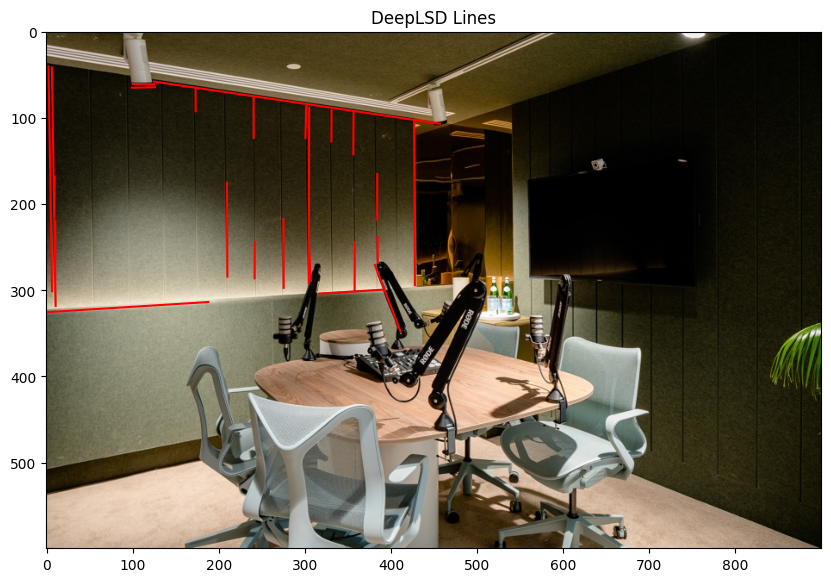

In [23]:
plt.figure(figsize=(10, 8))
plt.imshow(img, cmap='gray')  # Display the background image

# Plot each line segment
for line in intersecting_lines:
    plt.plot([line[0][0], line[1][0]], [line[0][1], line[1][1]], 'r-')  # Red lines

plt.title('DeepLSD Lines')
plt.show()

### 找出水平線

In [24]:
def classify_lines_with_slope(out: list) -> Tuple[NDArray[np.float32], NDArray[np.float32]]:
    lines = out
    x1, y1 = lines[:, 0, 0], lines[:, 0, 1]
    x2, y2 = lines[:, 1, 0], lines[:, 1, 1]

    vertical_mask = x2 == x1
    slopes = np.where(vertical_mask, np.Infinity, (y2 - y1) / (x2 - x1))
    horizontal_mask = np.abs(slopes) <= 1

    vertical_lines = lines[vertical_mask | ~horizontal_mask]
    horizontal_lines = lines[horizontal_mask]

    return horizontal_lines, vertical_lines


In [25]:
combined_array = np.empty((0, 2, 2))

for line in intersecting_lines:
    new_line_array = np.array([[line[0][0], line[0][1]], [line[1][0], line[1][1]]])
    combined_array = np.append(combined_array, [new_line_array], axis=0)

In [26]:
h_line, v_line = classify_lines_with_slope(combined_array)

In [27]:
h_line

array([[[316.92190552, 303.73025513],
        [390.01446533, 299.23519897]],

       [[124.63215637,  57.49801254],
        [456.79229736, 106.41059113]],

       [[  0.95315385, 325.25170898],
        [187.97142029, 313.5435791 ]],

       [[100.02787781,  60.32193756],
        [125.02098083,  60.73715973]],

       [[ 98.9930191 ,  64.63672638],
        [126.02146912,  64.11727905]]])

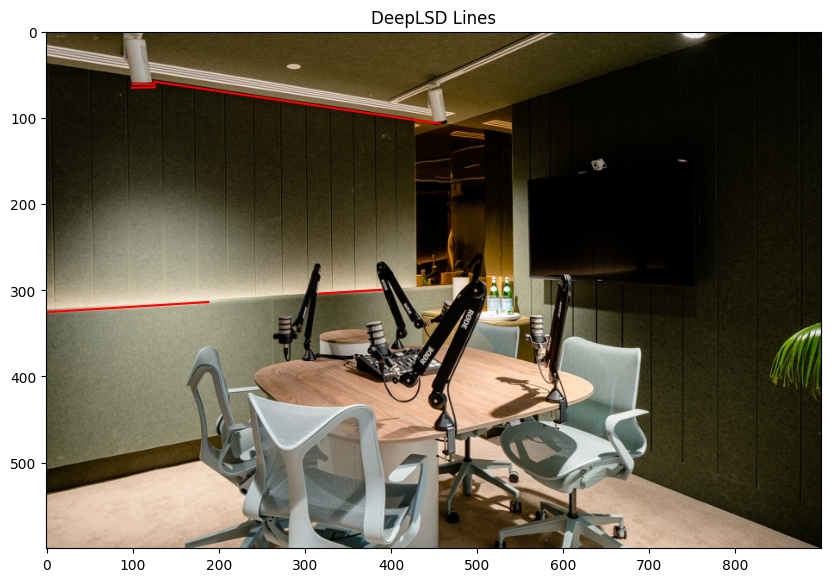

In [28]:
plt.figure(figsize=(10, 8))
plt.imshow(img, cmap='gray')  # Display the background image

# Plot each line segment
for line in h_line:
    plt.plot([line[0][0], line[1][0]], [line[0][1], line[1][1]], 'r-')  # Red lines

plt.title('DeepLSD Lines')
plt.show()

In [29]:
def find_2longest_line_length(linelist_for_compute):
    line_length = np.linalg.norm(line[1] - line[0])
    line_lengths = [(line, line_length(line)) for line in linelist_for_compute]
    # Sort the lines by length in descending order
    sorted_lines = sorted(line_lengths, key=lambda x: x[1], reverse=True)

    # Get the two longest lines
    longest_lines = sorted_lines[:2]
    
    # Extract the line coordinates from the result
    longest_lines_forreturn = [line[0] for line in longest_lines]
    return longest_lines_forreturn

In [30]:
def line_length(line):
    return np.linalg.norm(line[1] - line[0])

# Compute the lengths of each line
line_lengths = [(line, line_length(line)) for line in h_line]

# Sort the lines by length in descending order
sorted_lines = sorted(line_lengths, key=lambda x: x[1], reverse=True)

# Get the two longest lines
longest_lines = sorted_lines[:2]

# Extract the line coordinates from the result
h_lines = [line[0] for line in longest_lines]

print("兩條最長的線:")
for i, line in enumerate(h_lines, 1):
    print(f"Line {i}: {line} with length {line_length(line)}")

兩條最長的線:
Line 1: [[124.63215637  57.49801254]
 [456.79229736 106.41059113]] with length 335.74216239089805
Line 2: [[  0.95315385 325.25170898]
 [187.97142029 313.5435791 ]] with length 187.38439712891085


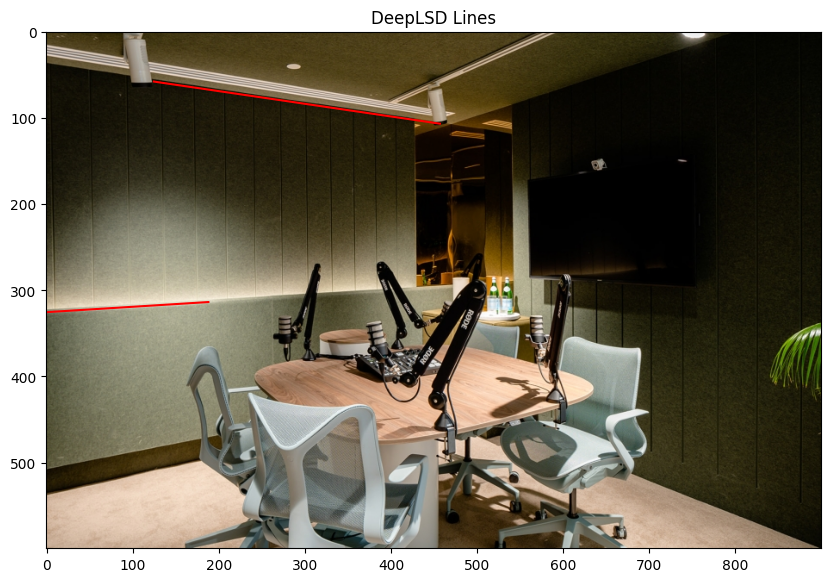

In [31]:
plt.figure(figsize=(10, 8))
plt.imshow(img, cmap='gray')  # Display the background image

# Plot each line segment
for line in h_lines:
    plt.plot([line[0][0], line[1][0]], [line[0][1], line[1][1]], 'r-')  # Red lines

plt.title('DeepLSD Lines')
plt.show()

In [57]:
import numpy as np

def calculate_vanishing_point(line1, line2):
    # 從每條線中提取兩個點
    x1, y1 = line1[0]
    x2, y2 = line1[1]
    x3, y3 = line2[0]
    x4, y4 = line2[1]
    
    # 計算線的斜率和y截距
    m1 = (y2 - y1) / (x2 - x1) if x2 != x1 else float('inf')
    b1 = y1 - m1 * x1 if m1 != float('inf') else None
    
    m2 = (y4 - y3) / (x4 - x3) if x4 != x3 else float('inf')
    b2 = y3 - m2 * x3 if m2 != float('inf') else None
    
    # 處理平行線的情況
    if m1 == m2:
        return None  # 平行線沒有交點
    
    # 計算交點
    if m1 == float('inf'):
        x = x1
        y = m2 * x + b2
    elif m2 == float('inf'):
        x = x3
        y = m1 * x + b1
    else:
        x = (b2 - b1) / (m1 - m2)
        y = m1 * x + b1
    
    return (x, y)

# 示例線段
line1 = np.array(h_lines[0], dtype=np.float32)
line2 = np.array(h_lines[1], dtype=np.float32)

# 計算消失點
vanishing_point = calculate_vanishing_point(line1, line2)
if vanishing_point is not None:
    print(f"消失點坐標: {vanishing_point}")
else:
    print("兩條線平行，沒有交點")

消失點坐標: (1363.6039, 239.94403)


### 調整圖片

In [71]:
from depthmap_package import convert_to_i16, get_depthmap_new, display_resized, binarized, resized
from Process_package import get_largest_inner_box

def show_box(box, ax, edgecolor='green'):
    """
    Show bounding box on the plot.

    Args:
    box: The bounding box coordinates.
    ax: The axis of the plot.
    edgecolor (str): The color of the bounding box. Defaults to 'green'.
    """
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor=edgecolor, facecolor=(0, 0, 0, 0), lw=2))

def find_min_bounding_box_from_img(image: Image) -> np.array:
    """
    Find the minimum bounding box from the input image.

    Args:
    image (Image): The input image.

    Returns:
    np.array: The coordinates of the bounding box.
    """
    image_array = np.array(image.convert('L'))  # convert Image into np.array
    image_array = 255 - image_array  # invert black & white since cv2.findContours finds the white part only
    contours, _ = cv2.findContours(image_array, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    x, y, w, h = cv2.boundingRect(np.concatenate(contours))
    return np.array([x, y, x + w, y + h])

def binarized(image: Image, threshold=38, target_ratio=40) -> Image:
    """
    Binarize the input image.

    Args:
    image (Image): The input image.
    threshold (int): The threshold value for binarization. Defaults to 38 in Amazon demo figure.

    Returns:
    Image: The binarized image.
    """
    assert image.mode == 'I' or image.mode == 'I;16', image.mode
    assert isinstance(threshold, int) and 0 < threshold < 100
    assert isinstance(target_ratio, int) and 0 < target_ratio < 100

    image_array = np.array(image) // 256
    image_array = image_array.astype(np.uint8)

    black_ratio = 0
    while black_ratio < target_ratio / 100:
        _, bin_image = cv2.threshold(image_array, int(threshold/100*255), 255, cv2.THRESH_BINARY)
        black_pixels = np.count_nonzero(bin_image == 0)
        total_pixels = bin_image.size
        black_ratio = black_pixels / total_pixels
        threshold+=1

    return (binarized_image := Image.fromarray(bin_image))

def get_result_from_SAM(original_img: Image, input_box=tuple()) -> np.array:
    """
    Get segmentation result from the SAM model.

    Args:
    original_img (Image): The original image.
    input_box (tuple): The input bounding box. Defaults to an empty tuple.

    Returns:
    np.array: The segmentation masks.
    """
    global PREDICTOR

    image = np.array(original_img.convert('RGB'))

    if isinstance(PREDICTOR, SamPredictor):
        PREDICTOR.set_image(image)
        masks, _, _ = PREDICTOR.predict(box=input_box[None, :], multimask_output=False)

    elif isinstance(PREDICTOR, SamAutomaticMaskGenerator):
        masks = PREDICTOR.generate(image)
        masks = sorted(masks, key=(lambda x: x['area']), reverse=True)

    else:
        raise TypeError("PREDICTOR should be SamPredictor or SamAutomaticMaskGenerator!")

    return masks


def get_largest_inner_box(mask:np.array, target_ratio=.00, tolerance=.01, bounding_box_size = .09) -> np.array:
    """
    Get the largest inner box from the segmentation mask.

    Args:
    mask (np.array): The segmentation mask.
    target_ratio = (float): The target ratio of the largest inner box.
    tolerance (float): The tolerance of the largest inner box.

    Returns:
    np.array: The coordinates of the largest inner box.
    """
    rows, cols = mask.shape
    max_area = 0
    max_rect = (0, 0, 0, 0)  # (x1, y1, x2, y2)

    # ref: LeetCode 84. Largest Rectangle in Histogram
    heights = np.zeros(cols)
    for y2 in range(rows):
        if (rows - y2) * cols < max_area: # The rest area is smaller than the max area
            break

        heights = (heights + 1) * mask[y2, :] # compute the heights (histogram)
        stack = [] # reset stack at every row
        for x2 in range(cols + 1):
            if (rows - y2) * (cols + 1 - x2) < max_area: # The rest area is smaller than the max area
                break

            while stack and (x2 == cols or heights[stack[-1]] > heights[x2]):
                height = heights[stack.pop()]
                width = x2 if not stack else x2 - stack[-1] - 1
                curr_ratio = width / height if height > 0 else 0 # prevent ZeroDivisionError
                if target_ratio * (1 - tolerance) <= curr_ratio <= target_ratio * (1 + tolerance) or target_ratio == 0:
                    area = width * height
                    if area > max_area:
                        max_area = area
                        x1 = 0 if not stack else stack[-1] + 1
                        max_rect = (x1, y2 - height + 1, x2 - 1, y2)

            stack.append(x2)

     # Calculate the 20% smaller rectangle
    x1, y1, x2, y2 = max_rect
    width = x2 - x1 + 1
    height = y2 - y1 + 1

    # Reduce width and height
    new_width = int(width * bounding_box_size)
    new_height = int(height * bounding_box_size)

    # Calculate new coordinates ensuring they are within bounds
    new_x1 = x1 + (width - new_width) // 2
    new_y1 = y1 + (height - new_height) // 2
    new_x2 = new_x1 + new_width - 1
    new_y2 = new_y1 + new_height - 1

    # Ensure coordinates are within bounds
    new_x1 = max(0, new_x1)
    new_y1 = max(0, new_y1)
    new_x2 = min(cols - 1, new_x2)
    new_y2 = min(rows - 1, new_y2)

    return np.array([new_x1, new_y1, new_x2, new_y2], dtype="uint32")


original_width = 900px
original_height = 600px


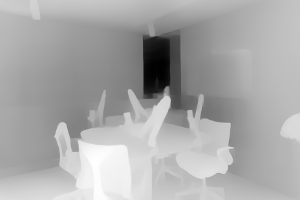

original_width = 900px
original_height = 600px


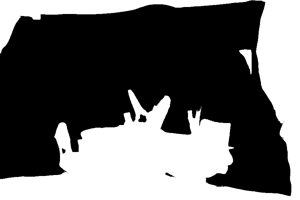

largest inner box on the binarized image:


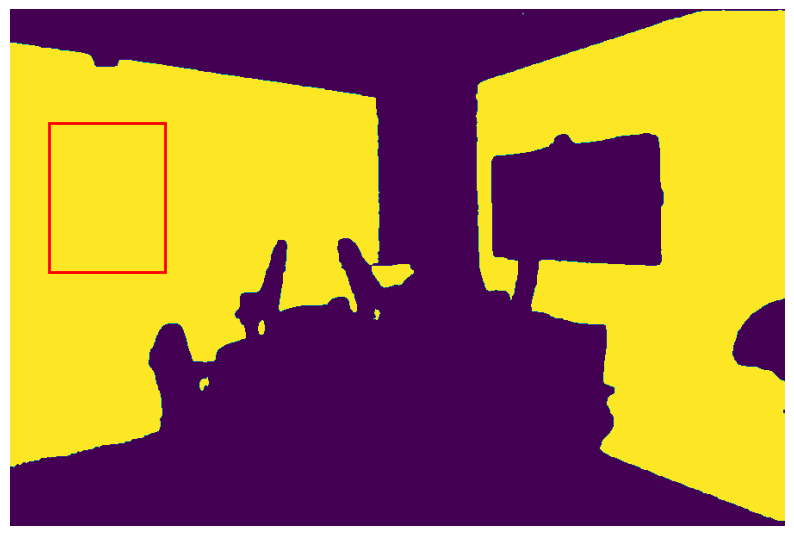

In [62]:

frame_name = 'recording_room.jpg'
ad_name = 'lisa.jpg'
original_img = Image.open(frame_name)

# 遮罩生成
TARGET_RATIO = 60 
depthmap = get_depthmap_new(original_img, model_holder)
display_resized(depthmap, new_height=200) 

# try to binarize the output depthmap for finding errors
binarized_img = binarized(depthmap, target_ratio=TARGET_RATIO)
display_resized(binarized_img, new_height=200)

#bounding box
bounding_box = find_min_bounding_box_from_img(binarized_img)

masks = get_result_from_SAM(original_img, bounding_box)
mask = masks[0] if USE_DEPTHMAP else masks[0]["segmentation"]
#display_resized(mask, new_height=200)
color = np.array([0, 0, 0, 1.0])
h, w = mask.shape[-2:]
mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)


def get_mask(img): 
    img_arr = np.array(img)[:, :, 3] #get alpha only
    img_arr = (img_arr > .5).astype(bool)
    return img_arr
mask = get_mask(mask_image)

original_img = Image.open(frame_name)
ad_img = Image.open(ad_name)
w, h = ad_img.size
target_ratio = w / h
(largest_inner_box := get_largest_inner_box(mask, target_ratio, bounding_box_size = 0.6))
print("largest inner box on the binarized image:")
plt.figure(figsize=(10,10))
show_box(largest_inner_box, plt.gca(), edgecolor='red')
plt.axis('off')
plt.gca().imshow(mask)
plt.show()

In [63]:
r_inner_box = []
inner_box = [[largest_inner_box[0], largest_inner_box[1]],[largest_inner_box[2], largest_inner_box[1]],
              [largest_inner_box[0],largest_inner_box[3]], [largest_inner_box[2], largest_inner_box[3]]]
print(f'largest_inner_box {largest_inner_box}')

#rect分別為(左上角, 右上角)
rect = ((largest_inner_box[0], largest_inner_box[1]), (largest_inner_box[2], largest_inner_box[3]))
# 分別找出最合適上邊以及下邊，最低長度至少要是最長的10%(可調整)
# 主要邏輯是先找有相交的線，若沒有再上邊往上找下邊往下找

top_edge = [inner_box[0], inner_box[1]]
bottom_edge = [inner_box[2], inner_box[3]]

print(f'上邊{top_edge} 下邊{bottom_edge}')

largest_inner_box [ 45 131 179 305]
上邊[[45, 131], [179, 131]] 下邊[[45, 305], [179, 305]]


In [64]:
def adjust_vanishing_point(line1, line2, new_vanishing_point):
    # 計算線段的方向向量
    dir1 = np.array(line1[1]) - np.array(line1[0])
    dir2 = np.array(line2[1]) - np.array(line2[0])
    
    # 計算新的方向向量
    new_dir1 = np.array(new_vanishing_point) - np.array(line1[0])
    new_dir2 = np.array(new_vanishing_point) - np.array(line2[0])
    
    # 計算縮放因子
    scale1 = np.linalg.norm(dir1) / np.linalg.norm(new_dir1)
    scale2 = np.linalg.norm(dir2) / np.linalg.norm(new_dir2)
    
    # 計算新的終點
    new_end1 = np.array(line1[0]) + new_dir1 * scale1
    new_end2 = np.array(line2[0]) + new_dir2 * scale2
    
    # 返回新的線段
    return [line1[0], new_end1.tolist()], [line2[0], new_end2.tolist()]

# 新的消失點
new_vanishing_point = [1363.6039, 239.94403]

# 調整線段
new_line1, new_line2 = adjust_vanishing_point(top_edge, bottom_edge, new_vanishing_point)

print("調整後的線段1:", new_line1)
print("調整後的線段2:", new_line2)

調整後的線段1: [[45, 131], [178.54497374240128, 142.03358455540848]]
調整後的線段2: [[45, 305], [178.83720973236865, 298.3968726307933]]


調整後位置:[[ 45.         131.        ]
 [178.54497374 142.03358456]
 [178.83720973 298.39687263]
 [ 45.         305.        ]]


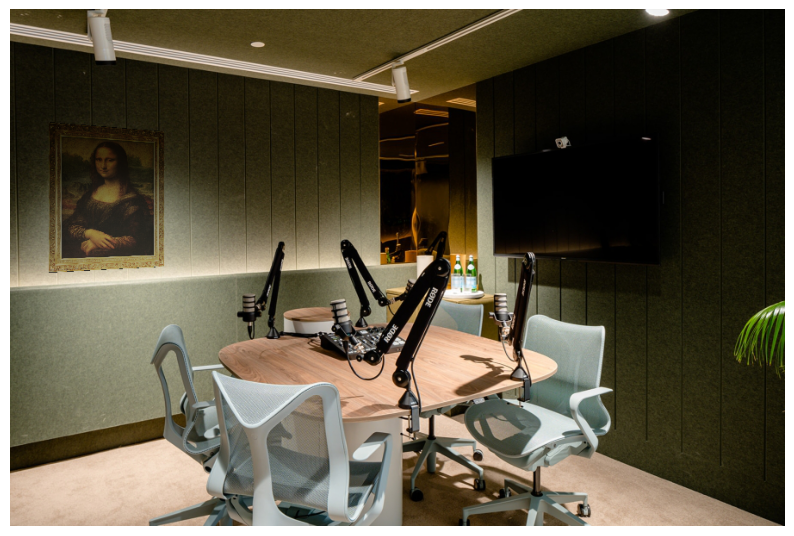

In [65]:
from Process_package import get_mask, paste_quadrilateral_ad
loc = np.array([new_line1[0], new_line1[1], new_line2[1], new_line2[0]]) #最終調整後位置
print(f'調整後位置:{loc}')
combined_image = paste_quadrilateral_ad(original_img, ad_img, loc, mask)
plt.figure(figsize=(10,10))
plt.imshow(combined_image)
plt.axis('off')
plt.show()

## 原始

In [67]:
import numpy as np

def line_in_rect(line, rect):
    """
    檢查線段是否完全或部分包含在矩形內。

    參數:
    line: 每條預測出來的線
    rect: 我們的矩形區域
    """
    x0, y0 = rect[0]
    x1, y1 = rect[1]
    line_x1, line_y1, line_x2, line_y2 = line[0][0], line[0][1], line[1][0], line[1][1]

    # 檢查線段的兩個端點是否至少有一個在矩形內
    if (x0 <= line_x1 <= x1 and y0 <= line_y1 <= y1) or (x0 <= line_x2 <= x1 and y0 <= line_y2 <= y1):
        return True

    # 檢查線段是否與矩形的任何一邊相交
    rect_sides = [
        (x0, y0, x1, y0),  # 上
        (x1, y0, x1, y1),  # 右
        (x1, y1, x0, y1),  # 下
        (x0, y1, x0, y0)   # 左
    ]
    for side in rect_sides:
        if line_intersects_side((line_x1, line_y1, line_x2, line_y2), side):
            return True

    return False

def line_intersects_side(line, side):
    """
    檢查線段是否與線段相交。
    """
    x1, y1, x2, y2 = line
    x3, y3, x4, y4 = side

    # 解決垂直線段問題
    def compute_line_params(x1, y1, x2, y2):
        if x2 != x1:
            m = (y2 - y1) / (x2 - x1)
            b = y1 - m * x1
        else:
            m = np.inf  # 代表無限斜率
            b = x1      # 用x坐標表示垂直線
        return m, b

    m1, b1 = compute_line_params(x1, y1, x2, y2)
    m2, b2 = compute_line_params(x3, y3, x4, y4)

    # 如果斜率相同，則平行或完全重合
    if m1 == m2:
        return False if m1 != np.inf else b1 == b2

    # 計算交點
    if m1 != np.inf and m2 != np.inf:
        x = (b2 - b1) / (m1 - m2)
        y = m1 * x + b1
    elif m1 == np.inf:
        x, y = b1, m2 * b1 + b2
    else:
        x, y = b2, m1 * b2 + b1

    # 檢查交點是否在兩條線段上
    return (min(x1, x2) <= x <= max(x1, x2) and min(x3, x4) <= x <= max(x3, x4) and
            min(y1, y2) <= y <= max(y1, y2) and min(y3, y4) <= y <= max(y3, y4))


In [68]:
from adjustment_package import classify_lines_with_slope
def find_transformation_lines(rect, edges, min_length_ratio=0.1):
    """
    根據給定的矩形和邊緣線段，找到最長的水平、垂直線段作為變換線。

    Args:
        rect (tuple): 矩形的左上角和右下角坐標，格式為 ((x1, y1), (x2, y2))
        edges (list): 邊緣線段的坐標列表，格式為 [((x1, y1), (x2, y2)), ...]
        min_length_ratio (float): 最小線段長度與矩形邊長的比率閾值，默認為 0.1

    Returns:
        tuple: (up_line, down_line, left_line, right_line)
            up_line (tuple): 最長的上方水平線段的坐標 ((x1, y1), (x2, y2))
            down_line (tuple): 最長的下方水平線段的坐標 ((x1, y1), (x2, y2))
    """
    print('套用成功')
    x1_rect, y1_rect = rect[0] #左上角
    x2_rect, y2_rect = rect[1] #右下角
    center_x = (x1_rect + x2_rect) / 2
    center_y = (y1_rect + y2_rect) / 2
    edge_length = max(x2_rect - x1_rect, y2_rect - y1_rect)
    min_length = min_length_ratio * edge_length

    # 初始化默認值
    up_line = down_line = None
    max_up_length = max_down_length =  0

    # 偏好框框內
    for line in edges:
            (lx1, ly1), (lx2, ly2) = line
            line_length = np.linalg.norm(np.array([lx2, ly2]) - np.array([lx1, ly1]))
            if line_length >= min_length:
                if line_in_rect(line, rect):
                    down_line = ((lx1, ly1), (lx2, ly2))
                    print('上方矩形內')
    

    # 偏好框框內
    for line in edges:
            (lx1, ly1), (lx2, ly2) = line
            line_length = np.linalg.norm(np.array([lx2, ly2]) - np.array([lx1, ly1]))
            if line_length >= min_length:
                if line_in_rect(line, rect):
                    up_line = ((lx1, ly1), (lx2, ly2))
                    print('下方矩形內')
    
    #如果找不到則往上或下找
    closest_distance_down = float('inf')
    if down_line is None:
        for line in edges:
            (x1, y1), (x2, y2) = line
            line_length = np.linalg.norm(np.array([x2, y2]) - np.array([x1, y1]))
            if line_length >= min_length:
                if int(x1_rect) in range(int(x1), int(x2)) or int(x2_rect) in range(int(x1), int(x2)) or x1 in range(x1_rect, x2_rect) or x2 in range(x1_rect, x2_rect):
                    if line_length > max_down_length:
                        distance = center_y - max(y1, y2)

                        if distance > 0 and distance < closest_distance_down:
                            closest_distance_down = distance
                            max_down_length = line_length
                            down_line = ((x1, y1), (x2, y2))
                            print('往下找到')
        if down_line is None:            
            for line in edges:
                (x1, y1), (x2, y2) = line
                line_length = np.linalg.norm(np.array([x2, y2]) - np.array([x1, y1]))
                if line_length >= min_length:
                    if y1 <= center_y and y2 <= center_y:
                        if line_length > max_down_length:
                            max_down_length = line_length
                            down_line = ((x1, y1), (x2, y2))
                            print('下方都沒找到全圖找')
    
    closest_distance_up = float('inf')
    if up_line is None:
        for line in edges:
            (x1, y1), (x2, y2) = line
            line_length = np.linalg.norm(np.array([x2, y2]) - np.array([x1, y1]))
            if line_length >= min_length:
                if int(x1_rect) in range(int(x1), int(x2)) or int(x2_rect) in range(int(x1), int(x2))or x1 in range(x1_rect, x2_rect) or x2 in range(x1_rect, x2_rect):
                    if y1 >= center_y and y2 >= center_y:
                        distance = center_y - max(y1, y2)

                        if distance > 0 and distance < closest_distance_up:
                            closest_distance_up = distance
                            up_line = ((x1, y1), (x2, y2))
                            print('往上找到')
        if up_line is None:
            for line in edges:
                (x1, y1), (x2, y2) = line
                line_length = np.linalg.norm(np.array([x2, y2]) - np.array([x1, y1]))
                if line_length >= min_length:
                    if y1 >= center_y and y2 >= center_y:
                        
                        if line_length > max_up_length:
                            max_up_length = line_length
                            up_line = ((x1, y1), (x2, y2))
                            print('上方都沒找到全圖找')
        if up_line is None:
            up_line = down_line
        if down_line is None:
            down_line = up_line

    return down_line, up_line

def mcompute_adjusted_region_points(line_points, horizontal_line):
    """
    根據指定的線段和新起點生成平行線段

    Args:
        line_points: 線段的兩個座標點
        horizontal_line: 目標線段的兩個座標點

    Returns:
        list: 返回新線段的起點和終點座標 (new_x1, new_y1, new_x2, new_y2)
    """
    (hx1, hy1), (hx2, hy2) = horizontal_line
    
    # 計算目標線段的斜率
    if hx2 != hx1:
        m = (hy2 - hy1) / (hx2 - hx1)
    else:
        # 如果線段是垂直的，斜率無限大
        m = float('inf')
    
    # 提取線段的起點和終點
    x1, y1 = line_points[0]
    x2, y2 = line_points[1]
    
    # 計算新線段的起點和終點
    if m != float('inf'):
        # 斜率不無限大情況下的計算
        length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        new_x1 = x1
        new_y1 = y1 + m * (new_x1 - x1)
        new_x2 = new_x1 + length / (1 + m**2)**0.5
        new_y2 = new_y1 + m * (new_x2 - new_x1)
    else:
        print('inf')
        # 垂直線段的計算
        new_x1 = x1
        new_y1 = y1
        new_x2 = x1
        new_y2 = y1 + (y2 - y1)
    
    return [(new_x1, new_y1), (new_x2, new_y2)]

In [ ]:
def get_largest_inner_box(mask:np.array, target_ratio=.00, tolerance=.01, bounding_box_size = .09) -> np.array:
    """
    Get the largest inner box from the segmentation mask.

    Args:
    mask (np.array): The segmentation mask.
    target_ratio = (float): The target ratio of the largest inner box.
    tolerance (float): The tolerance of the largest inner box.

    Returns:
    np.array: The coordinates of the largest inner box.
    """
    rows, cols = mask.shape
    max_area = 0
    max_rect = (0, 0, 0, 0)  # (x1, y1, x2, y2)

    # ref: LeetCode 84. Largest Rectangle in Histogram
    heights = np.zeros(cols)
    for y2 in range(rows):
        if (rows - y2) * cols < max_area: # The rest area is smaller than the max area
            break

        heights = (heights + 1) * mask[y2, :] # compute the heights (histogram)
        stack = [] # reset stack at every row
        for x2 in range(cols + 1):
            if (rows - y2) * (cols + 1 - x2) < max_area: # The rest area is smaller than the max area
                break

            while stack and (x2 == cols or heights[stack[-1]] > heights[x2]):
                height = heights[stack.pop()]
                width = x2 if not stack else x2 - stack[-1] - 1
                curr_ratio = width / height if height > 0 else 0 # prevent ZeroDivisionError
                if target_ratio * (1 - tolerance) <= curr_ratio <= target_ratio * (1 + tolerance) or target_ratio == 0:
                    area = width * height
                    if area > max_area:
                        max_area = area
                        x1 = 0 if not stack else stack[-1] + 1
                        max_rect = (x1, y2 - height + 1, x2 - 1, y2)

            stack.append(x2)

     # Calculate the 20% smaller rectangle
    x1, y1, x2, y2 = max_rect
    width = x2 - x1 + 1
    height = y2 - y1 + 1

    # Reduce width and height
    new_width = int(width * bounding_box_size)
    new_height = int(height * bounding_box_size)

    # Calculate new coordinates ensuring they are within bounds
    new_x1 = x1 + (width - new_width) // 2
    new_y1 = y1 + (height - new_height) // 2
    new_x2 = new_x1 + new_width - 1
    new_y2 = new_y1 + new_height - 1

    # Ensure coordinates are within bounds
    new_x1 = max(0, new_x1)
    new_y1 = max(0, new_y1)
    new_x2 = min(cols - 1, new_x2)
    new_y2 = min(rows - 1, new_y2)

    return np.array([new_x1, new_y1, new_x2, new_y2], dtype="uint32")

original_width = 1517px
original_height = 859px


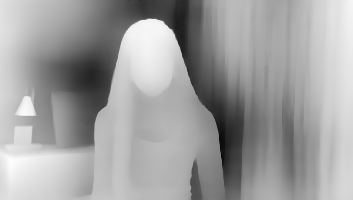

original_width = 1517px
original_height = 859px


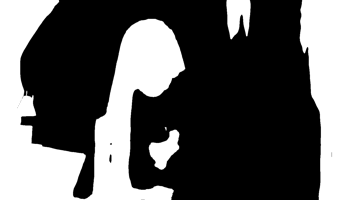

largest inner box on the binarized image:


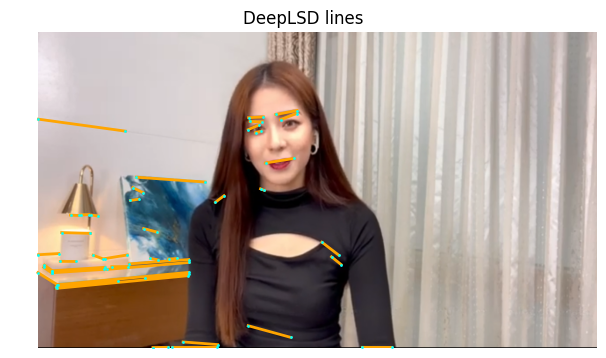

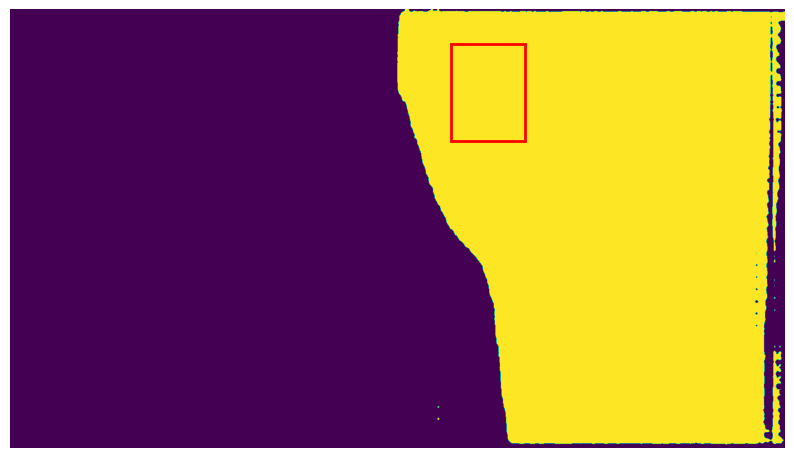

largest_inner_box [ 863   68 1008  257]
套用成功
上方都沒找到全圖找
上方都沒找到全圖找
上方都沒找到全圖找
上方都沒找到全圖找
上方都沒找到全圖找
調整後位置:[[ 863.           68.        ]
 [1007.34906501   54.27602715]
 [1007.34906501  243.27602715]
 [ 863.          257.        ]]


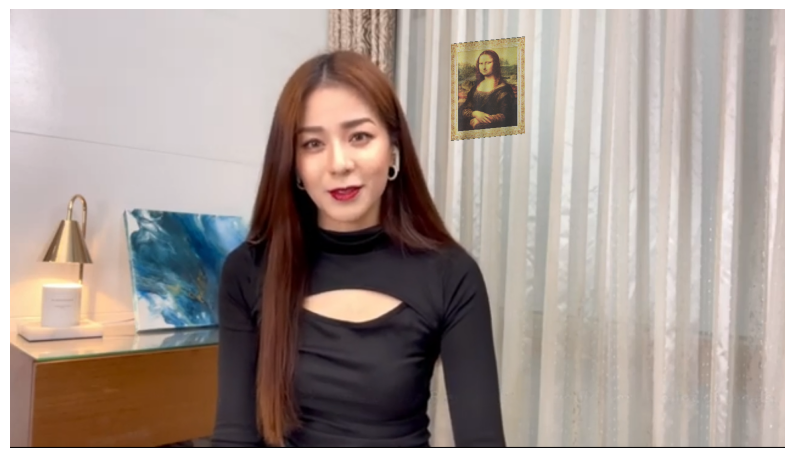

In [75]:

frame_name = 'frame1.png'
ad_name = 'lisa.jpg'
original_img = Image.open(frame_name)


# Model config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
conf = {
    'detect_lines': True,  # Whether to detect lines or only distance field/angle field
    'line_detection_params': {
        'merge': True,  # Whether to merge close-by lines
        'filtering': True,  # Whether to filter out lines based on the distance field/angle field. Use 'strict' to get an even stricter filtering
        'grad_thresh': 2,
        'grad_nfa': True,  # If True, use the image gradient and the NFA score of LSD to further threshold lines. We recommand using it for easy images, but to turn it off for challenging images (e.g. night, foggy, blurry images)
    }
}

# Load the model
ckpt = 'C:/Users/ASUS/DeepLSD/weights/deeplsd_md.tar'
# ckpt = '/Volumes/Seagate Bac/models/computer_vision/deeplsd/deeplsd_md.tar' # outdoor
# ckpt = '/Volumes/Seagate Bac/models/computer_vision/deeplsd/deeplsd_wireframe.tar' # indoor
ckpt = torch.load(str(ckpt), map_location='cpu')
net = DeepLSD(conf)
net.load_state_dict(ckpt['model'])
net = net.to(device).eval()

###################################################################
# 遮罩生成
TARGET_RATIO = 60 
depthmap = get_depthmap_new(original_img, model_holder)
display_resized(depthmap, new_height=200) 

# try to binarize the output depthmap for finding errors
binarized_img = binarized(depthmap, target_ratio=TARGET_RATIO)
display_resized(binarized_img, new_height=200)

#bounding box
bounding_box = find_min_bounding_box_from_img(binarized_img)

masks = get_result_from_SAM(original_img, bounding_box)
mask = masks[0] if USE_DEPTHMAP else masks[0]["segmentation"]
#display_resized(mask, new_height=200)
color = np.array([0, 0, 0, 1.0])
h, w = mask.shape[-2:]
mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)


def get_mask(img): 
    img_arr = np.array(img)[:, :, 3] #get alpha only
    img_arr = (img_arr > .5).astype(bool)
    return img_arr
mask = get_mask(mask_image)


###################################################################
#DeepLSD
originaltask_img = cv2.imread(frame_name)[:, :, ::-1]
gray_img = cv2.cvtColor(originaltask_img, cv2.COLOR_RGB2GRAY)
inputs = {'image': torch.tensor(gray_img, dtype=torch.float, device=device)[None, None] / 255.}
with torch.no_grad():
  out = net(inputs)
  pred_lines = out['lines'][0]
  #show_visualized_info(out)
  horizontal_list, vertical_list = classify_lines_with_slope(out)
plot_images([original_img], ['DeepLSD lines'], cmaps='gray')
plot_lines([horizontal_list], indices=range(1))

###################################################################
#自動找出最適合區塊置放廣告
original_img = Image.open(frame_name)
ad_img = Image.open(ad_name)
w, h = ad_img.size
target_ratio = w / h
(largest_inner_box := get_largest_inner_box(mask, target_ratio, bounding_box_size = 0.6))
print("largest inner box on the binarized image:")
plt.figure(figsize=(10,10))
show_box(largest_inner_box, plt.gca(), edgecolor='red')
plt.axis('off')
plt.gca().imshow(mask)
plt.show()

###################################################################
#根據框框調整角度
r_inner_box = []
inner_box = [[largest_inner_box[0], largest_inner_box[1]],[largest_inner_box[2], largest_inner_box[1]],
              [largest_inner_box[0],largest_inner_box[3]], [largest_inner_box[2], largest_inner_box[3]]]
print(f'largest_inner_box {largest_inner_box}')
horizontal_list, vertical_list = classify_lines_with_slope(out) #分類水平以及垂直線

#rect分別為(左上角, 右上角)
rect = ((largest_inner_box[0], largest_inner_box[1]), (largest_inner_box[2], largest_inner_box[3]))

# 分別找出最合適上邊以及下邊，最低長度至少要是最長的10%(可調整)
# 主要邏輯是先找有相交的線，若沒有再上邊往上找下邊往下找
up_line, down_line = find_transformation_lines(rect, horizontal_list)

top_edge = [inner_box[0], inner_box[1]]
bottom_edge = [inner_box[2], inner_box[3]]
# 調整上邊
new_top_edge = mcompute_adjusted_region_points(top_edge, up_line)

# 調整下邊
new_bottom_edge = mcompute_adjusted_region_points(bottom_edge, down_line)

inner_box[0], inner_box[1] = new_top_edge
inner_box[2], inner_box[3] = new_bottom_edge
loc = np.array([inner_box[0], inner_box[1], inner_box[3], inner_box[2]]) #最終調整後位置
print(f'調整後位置:{loc}')
combined_image = paste_quadrilateral_ad(original_img, ad_img, loc, mask)
plt.figure(figsize=(10,10))
plt.imshow(combined_image)
plt.axis('off')
plt.show()